# English Premier League Analysis
## From this analysis I would like to know:
> - What makes a team to get into top 4 in the league so that they are qualified to participate in Champions League?  
- Can we predict which teams are going to be in top4 based on team's statistics?

In [1]:
# Dependencies
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import warnings
import datetime
import platform

# ML
from sklearn.feature_selection import SelectKBest, chi2, RFE
from sklearn.preprocessing import scale
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer
from sklearn.utils import shuffle
from sklearn import svm
from sklearn import preprocessing
from xgboost import XGBClassifier


%matplotlib inline
plt.style.use('seaborn-whitegrid')
warnings.filterwarnings("ignore")

In [2]:
# load dataset
if platform.system() == 'Windows':
    tables = pd.read_csv('tables_crawler/tables_crawler/spiders/tables.csv')
    clubstats = pd.read_csv('clubstats_crawler/clubstats_crawler/spiders/clubstats.csv')
else:
    pass

In [3]:
tables.shape[0]

566

In [4]:
print('Rows: {}, Cols: {}'.format(tables.shape[0],tables.shape[1]))
tables

Rows: 566, Cols: 8


,club_name,drawn,goal,goal_against,lost,points,position,won
0,Liverpool,1,66,21,1,82,1,27
1,Manchester City,3,68,31,7,57,2,18
2,Leicester City,5,58,28,8,53,3,16
3,Chelsea,6,51,39,9,48,4,14
4,Manchester United,9,44,30,8,45,5,12
...,...,...,...,...,...,...,...,...
561,Southampton,11,54,61,18,50,18,13
562,Oldham Athletic,10,63,74,19,49,19,13
563,Crystal Palace,16,48,61,15,49,20,11
564,Middlesbrough,11,54,75,20,44,21,11


In [5]:
print('Rows: {}, Cols: {}'.format(clubstats.shape[0], clubstats.shape[1]))
clubstats

Rows: 566, Cols: 15


,aerial_battles,big_chance_created,clearance,club_name,cross,cross_accuracy,goal_conceded_per_match,goal_per_match,interceptions,pass_accuracy,pass_per_game,season,shooting_accuracy,shot_on_target,tackle_success
0,"1,853",38,519,Arsenal,548,22%,1.29,1.43,258,84%,507.11,2019/20,35%,109,58%
1,"2,489",72,762,Arsenal,605,21%,1.34,1.92,412,83%,547.50,2018/19,36%,170,60%
2,"2,660",81,829,Arsenal,572,21%,1.34,1.95,427,84%,619.05,2017/18,39%,234,68%
3,"2,762",55,838,Arsenal,697,22%,1.16,2.03,536,84%,563.00,2016/17,36%,201,70%
4,"2,785",88,849,Arsenal,754,25%,0.95,1.71,734,84%,559.18,2015/16,37%,211,73%
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
561,0,0,0,Nottingham Forest,0,0%,1.48,0.98,0,0%,0.00,1992/93,0%,0,0%
562,0,0,0,Barnsley,0,0%,2.16,0.97,0,0%,0.00,1997/98,0%,0,0%
563,0,0,0,Oldham Athletic,0,0%,1.62,1.00,0,0%,0.00,1993/94,0%,0,0%
564,0,0,0,Oldham Athletic,0,0%,1.76,1.50,0,0%,0.00,1992/93,0%,0,0%


**Total rows: 566, Total cols: 23**

## Data Preprocessing
> - Change into proper data types  
- Handling NA values

In [6]:
tables.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 566 entries, 0 to 565
Data columns (total 8 columns):
club_name       566 non-null object
drawn           566 non-null int64
goal            566 non-null int64
goal_against    566 non-null int64
lost            566 non-null int64
points          566 non-null int64
position        566 non-null int64
won             566 non-null int64
dtypes: int64(7), object(1)
memory usage: 35.5+ KB


**'tables' is already in proper data types. Also no NA values**

In [7]:
clubstats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 566 entries, 0 to 565
Data columns (total 15 columns):
aerial_battles             566 non-null object
big_chance_created         566 non-null int64
clearance                  566 non-null object
club_name                  566 non-null object
cross                      566 non-null object
cross_accuracy             566 non-null object
goal_conceded_per_match    566 non-null float64
goal_per_match             566 non-null float64
interceptions              566 non-null int64
pass_accuracy              566 non-null object
pass_per_game              566 non-null float64
season                     566 non-null object
shooting_accuracy          566 non-null object
shot_on_target             566 non-null int64
tackle_success             566 non-null object
dtypes: float64(3), int64(3), object(9)
memory usage: 66.5+ KB


In [8]:
# Change to proper data types
clubstats['cross_accuracy'] = clubstats['cross_accuracy'].map(lambda x: x.rstrip('%')).astype('int')
clubstats['pass_accuracy'] = clubstats['pass_accuracy'].map(lambda x: x.rstrip('%')).astype('int')
clubstats['shooting_accuracy'] = clubstats['shooting_accuracy'].map(lambda x: x.rstrip('%')).astype('int')
clubstats['tackle_success'] = clubstats['tackle_success'].map(lambda x: x.rstrip('%')).astype('int')
clubstats['aerial_battles'] = clubstats['aerial_battles'].str.replace(',','').astype('int')
clubstats['clearance'] = clubstats['clearance'].str.replace(',','').astype('int')
clubstats['cross'] = clubstats['cross'].str.replace(',','').astype('int')

# In 'clubstats' AFC Bournemouth is named as it is, but in 'tables' it is named as 'Bournemouth'.
# So in order to join the two data frames, the club_name for AFC Bournmouth has to be changed.
clubstats['club_name'][53] = 'Bournemouth'
clubstats['club_name'][54] = 'Bournemouth'
clubstats['club_name'][55] = 'Bournemouth'
clubstats['club_name'][56] = 'Bournemouth'
clubstats['club_name'][57] = 'Bournemouth'

**Need to join two tables, but there is no column that indicate what season it is on 'tables'.  Data were scraped descending order, which is 2019 to 1992, we just need to add the information on 'tables'.**

In [9]:
season_info = clubstats[clubstats['club_name'] == "Arsenal"]['season']
seasons = []

for i in range(len(season_info)):
    if i < 25:
        seasons.append([season_info[i],] * 20)
    else:
        seasons.append([season_info[i],] * 22)

seasons_flat = [season for sub_season in seasons for season in sub_season]
tables['season'] = seasons_flat

# Join two data frames
data = pd.merge(tables, clubstats, on=['club_name', 'season'])

# To get total number of games
data['total_games'] = data['won'] + data['drawn'] + data['lost']
# Add top4 indicator 
data['is_top4'] = data['position'].apply(lambda x: 1 if (x <= 4) else 0)

In [10]:
data.head(10)

,club_name,drawn,goal,goal_against,lost,points,position,won,season,aerial_battles,...,goal_conceded_per_match,goal_per_match,interceptions,pass_accuracy,pass_per_game,shooting_accuracy,shot_on_target,tackle_success,total_games,is_top4
0,Liverpool,1,66,21,1,82,1,27,2019/20,1982,...,0.72,2.28,267,84,622.17,39,176,60,29,1
1,Manchester City,3,68,31,7,57,2,18,2019/20,1747,...,1.11,2.43,263,89,675.89,35,192,58,28,1
2,Leicester City,5,58,28,8,53,3,16,2019/20,2183,...,1.03,2.00,330,82,516.31,38,154,58,29,1
3,Chelsea,6,51,39,9,48,4,14,2019/20,2265,...,1.34,1.76,363,85,602.00,35,169,56,29,1
4,Manchester United,9,44,30,8,45,5,12,2019/20,2018,...,1.03,1.52,286,82,503.31,39,166,57,29,0
5,Wolverhampton Wanderers,13,41,34,6,43,6,10,2019/20,2371,...,1.17,1.45,344,79,430.90,32,118,56,29,0
6,Sheffield United,10,30,25,7,43,7,11,2019/20,2334,...,0.89,1.07,322,74,395.61,32,92,62,28,0
7,Tottenham Hotspur,8,47,40,10,41,8,11,2019/20,2188,...,1.38,1.62,288,81,497.41,37,130,62,29,0
8,Arsenal,13,40,36,6,40,9,9,2019/20,1853,...,1.29,1.43,258,84,507.11,35,109,58,28,0
9,Burnley,6,34,40,12,39,10,11,2019/20,2372,...,1.38,1.17,298,68,325.66,35,104,63,29,0


In [11]:
# Since I want to predict top4 for this season, I will exclude this season
current_season = data[data['season'] == '2019/20']
past_seasons = data[data['season'] != '2019/20'].reset_index(drop=True)

# Change data type to datetime
current_season['season'] = pd.to_datetime(current_season['season'],format='%Y/%y')
past_seasons['season'] = pd.to_datetime(past_seasons['season'],format='%Y/%y')

## Exploratory Data Analysis 

In [12]:
past_seasons.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 546 entries, 0 to 545
Data columns (total 24 columns):
club_name                  546 non-null object
drawn                      546 non-null int64
goal                       546 non-null int64
goal_against               546 non-null int64
lost                       546 non-null int64
points                     546 non-null int64
position                   546 non-null int64
won                        546 non-null int64
season                     546 non-null datetime64[ns]
aerial_battles             546 non-null int32
big_chance_created         546 non-null int64
clearance                  546 non-null int32
cross                      546 non-null int32
cross_accuracy             546 non-null int32
goal_conceded_per_match    546 non-null float64
goal_per_match             546 non-null float64
interceptions              546 non-null int64
pass_accuracy              546 non-null int32
pass_per_game              546 non-null float64
shoot

In [13]:
top4 = past_seasons[past_seasons['is_top4'] == 1]
below4 = past_seasons[past_seasons['is_top4'] == 0]

In [145]:
def e_barplot(df1, df2, lists, **kwargs):
    """
    Optional parameters:
    
    w: width of plot, h: height of plot, figname: name of image when you save a plot as an image,
    save: whether to save a plot as an image, t_fsize: title font size, l_fsize: legend font size,
    label_size: X and Y axis font size, n_labels: name of labels, title: plot title, interval: interval of X tick.
    """
    plot_features = {}
    for key, value in kwargs.items():
        plot_features[key] = value
    # Set default values   
    if 'w' not in plot_features:
        plot_features['w'] = 10
    if 'h' not in plot_features:
        plot_features['h'] = 10
    if 'figname' not in plot_features:
        plot_features['figname'] = 'h_barplot'
    if 'save' not in plot_features:
        plot_features['save'] = False
    if 't_fsize' not in plot_features:
        plot_features['t_fsize'] = 20
    if 'l_fsize' not in plot_features:
        plot_features['l_fsize'] = 10
    if 'label_size' not in plot_features:
        plot_features['label_size'] = 20
    if 'n_labels' not in plot_features:
        plot_features['n_labels'] = ['First DF', 'Second DF']
    if 'title' not in plot_features:
        plot_features['title'] = None
    if 'interval' not in plot_features:
        plot_features['interval'] = 10
    if 'x_range' not in plot_features:
        plot_features['x_range'] = [0, 50]
    if 'vis_col' not in plot_features:
        plot_features['vis_col'] = 1
    if 'vis_row' not in plot_features:
        plot_features['vis_row'] = len(lists)
    if 'func' not in plot_features:
        plot_features['func'] = None
    
    if len(lists) == 1:
        plt.subplots(len(lists), 1, figsize = (plot_features['w'], plot_features['h']))
        plt.bar(df1[lists[0]].value_counts().sort_index().index, df1[lists[0]].value_counts().sort_index().values, 
                color='purple', label=plot_features['n_labels'][0])
        plt.bar(df2[lists[0]].value_counts().sort_index().index, df2[lists[0]].value_counts().sort_index().values, 
                color='navy', label=plot_features['n_labels'][1])
        plt.xticks(np.arange(plot_features['x_range'][0], plot_features['x_range'][1], plot_features['interval']))
        plt.legend(fontsize = plot_features['l_fsize']) 
        plt.title(plot_features['title'], fontsize=plot_features['t_fsize'])
        plt.tick_params(labelsize = plot_features['label_size'])
        plt.tight_layout()
        if plot_features['save'] == True:
            plt.savefig(plot_features['figname'] + '.jpg')
    
    elif plot_features['vis_col'] == 1:
        f, axes = plt.subplots(len(lists), 1, figsize = (plot_features['w'], plot_features['h']))
        
        for i in range(len(lists)):
            axes[i].bar(df1[lists[i]].value_counts().sort_index().index, df1[lists[i]].value_counts().sort_index().values, 
                        color='purple', label=plot_features['n_labels'][0])
            axes[i].bar(df2[lists[i]].value_counts().sort_index().index, df2[lists[i]].value_counts().sort_index().values, 
                        color='navy', label=plot_features['n_labels'][1])
            axes[i].legend(fontsize = plot_features['l_fsize']) 
            axes[i].set_xticks(np.arange(plot_features['x_range'][0], plot_features['x_range'][1], 
                                         plot_features['interval']))
            axes[i].set_title(lists[i], fontsize = plot_features['t_fsize'])
            axes[i].tick_params(labelsize=plot_features['label_size'])
            plt.tight_layout()
            if plot_features['save'] == True:
                plt.savefig(plot_features['figname'] + '.jpg')
    elif plot_features['func'] == 'average' and plot_features['vis_col'] > 1:
        r = plot_features['vis_row']
        c = plot_features['vis_col']
        
        r_uniq = list(np.arange(r))
        r_uniq = [[el] for el in r_uniq]
        c_uniq = list(np.arange(c))
        
        r_idx = []
        c_idx = []
        
        for num in r_uniq:
            r_idx += num * c
        for num in c_uniq:
            c_idx += num * r
        
        f, axes = plt.subplots(r, c, figsize = (plot_features['w'], plot_features['h']))
        
        for i in range(len(lists)):
            axes[r_idx[i], c_idx[i]].bar(0, np.average(df1[lists[i]]), 
                                         color='purple', label=plot_features['n_labels'][0])
            axes[r_idx[i], c_idx[i]].bar(1, np.average(df2[lists[i]]), 
                                         color='navy', label=plot_features['n_labels'][1])
            axes[r_idx[i], c_idx[i]].legend(fontsize = plot_features['l_fsize']) 
            axes[r_idx[i], c_idx[i]].set_xticks(np.arange(plot_features['x_range'][0], plot_features['x_range'][1], 
                                                          plot_features['interval']))
            axes[r_idx[i], c_idx[i]].set_title(lists[i], fontsize = plot_features['t_fsize'])
            axes[r_idx[i], c_idx[i]].tick_params(labelsize=plot_features['label_size'])
            plt.tight_layout()
            if plot_features['save'] == True:
                plt.savefig(plot_features['figname'] + '.jpg')       
    else:
        r = plot_features['vis_row']
        c = plot_features['vis_col']
        
        r_uniq = list(np.arange(r))
        r_uniq = [[el] for el in r_uniq]
        c_uniq = list(np.arange(c))
        
        r_idx = []
        c_idx = []
        
        for num in r_uniq:
            r_idx += num * c
        for num in c_uniq:
            c_idx += num * r
        
        f, axes = plt.subplots(r, c, figsize = (plot_features['w'], plot_features['h']))
        
        for i in range(len(lists)):
            axes[r_idx[i], c_idx[i]].bar(df1[lists[i]].value_counts().sort_index().index, df1[lists[i]].value_counts().sort_index().values, 
                        color='purple', label=plot_features['n_labels'][0])
            axes[r_idx[i], c_idx[i]].bar(df2[lists[i]].value_counts().sort_index().index, df2[lists[i]].value_counts().sort_index().values, 
                        color='navy', label=plot_features['n_labels'][1])
            axes[r_idx[i], c_idx[i]].legend(fontsize = plot_features['l_fsize']) 
            axes[r_idx[i], c_idx[i]].set_xticks(np.arange(plot_features['x_range'][0], plot_features['x_range'][1], 
                                         plot_features['interval']))
            axes[r_idx[i], c_idx[i]].set_title(lists[i], fontsize = plot_features['t_fsize'])
            axes[r_idx[i], c_idx[i]].tick_params(labelsize=plot_features['label_size'])
            plt.tight_layout()
            if plot_features['save'] == True:
                plt.savefig(plot_features['figname'] + '.jpg')


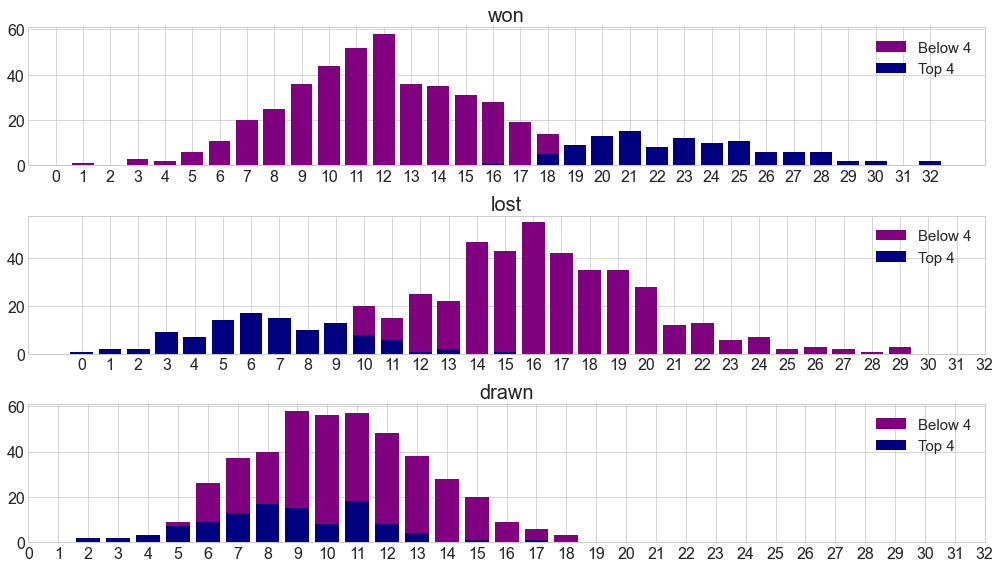

In [148]:
games = ['won', 'lost', 'drawn']

e_barplot(below4, top4, games, w=14, h=8, figname='result', save=True,
           t_fsize=20, l_fsize=15, label_size=16, n_labels=['Below 4', 'Top 4'], 
           interval=1, x_range=[0, 33])

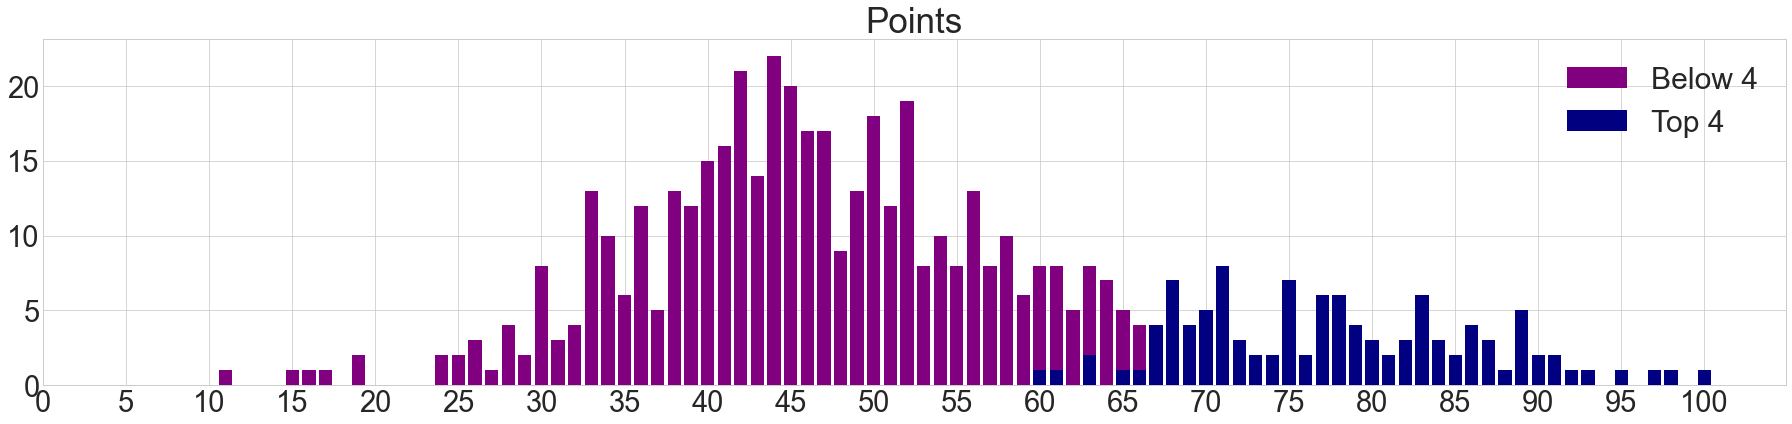

In [147]:
e_barplot(below4, top4, ['points'], w=25, h=6, figname='points', save=True,
           t_fsize=35, l_fsize=30, label_size=29, n_labels=['Below 4', 'Top 4'], 
           interval=5, title='Points', x_range=[0, 101])

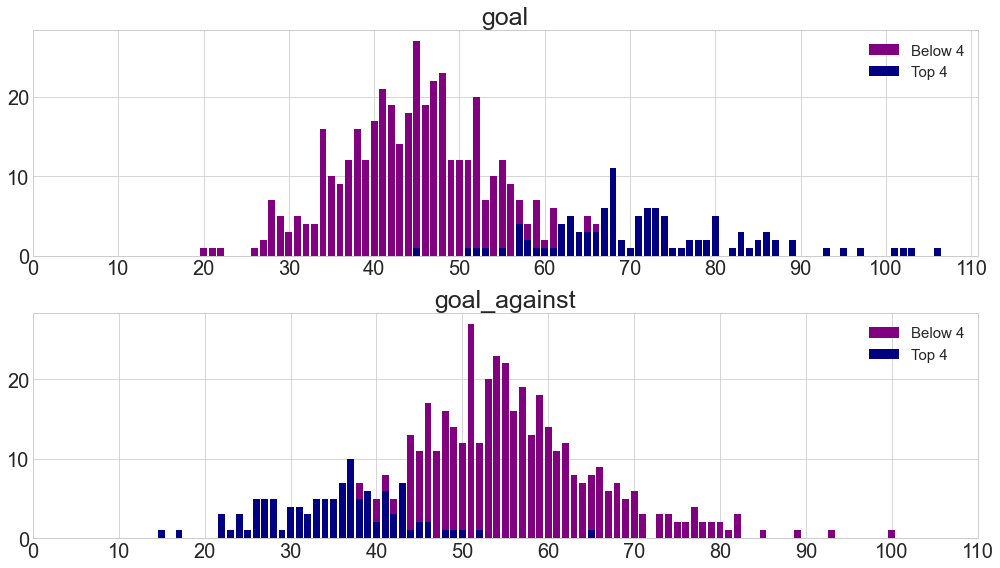

In [146]:
goals = ['goal', 'goal_against']

e_barplot(below4, top4, goals, w=14, h=8, figname='goals', save=True,
           t_fsize=25, l_fsize=15, label_size=20, n_labels=['Below 4', 'Top 4'], 
           interval=10, x_range=[0, 120])

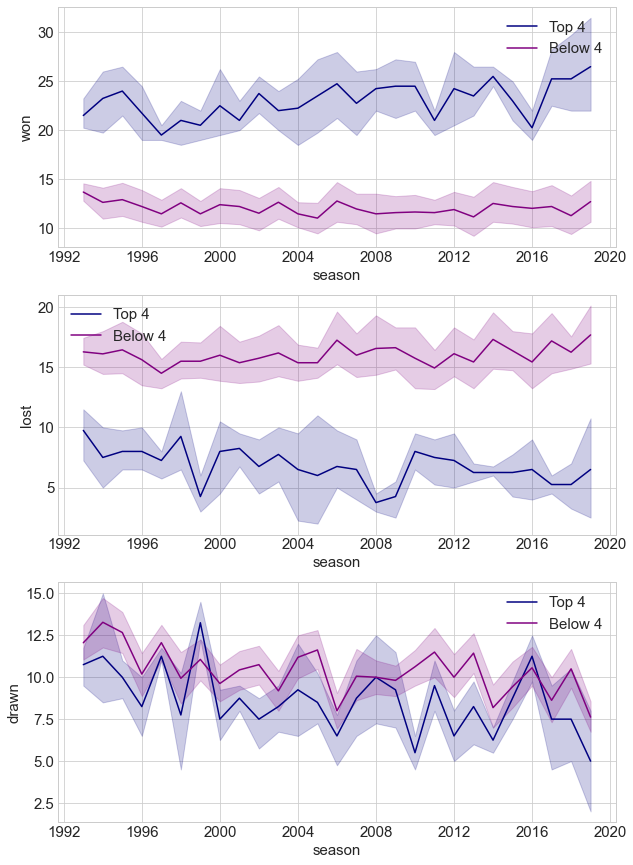

In [18]:
f, axes = plt.subplots(3, 1,figsize=(10, 15))

for i in range(len(games)):
    sns.lineplot(top4['season'], top4[games[i]], label=('Top 4'), color='navy',ax=axes[i])
    sns.lineplot(below4['season'], below4[games[i]], label=('Below 4'), color='purple', ax=axes[i])
    axes[i].tick_params(labelsize=15)
    axes[i].set_ylabel(games[i], fontsize=15)
    axes[i].set_xlabel('season', fontsize=15)
    axes[i].legend(fontsize=15) 

plt.savefig('timeline.jpg')

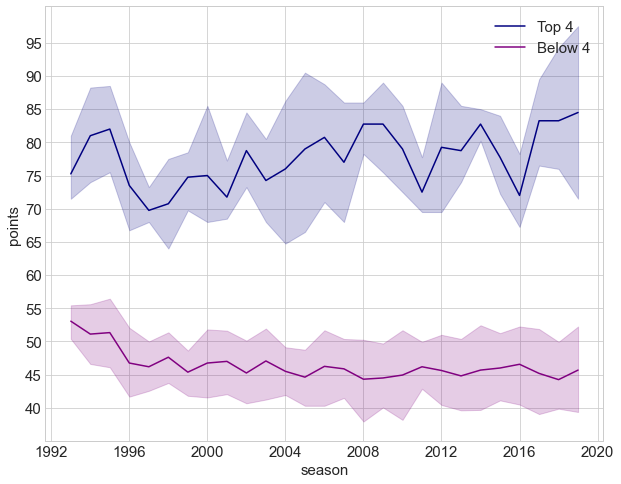

In [19]:
plt.figure(figsize=(10, 8))

sns.lineplot(top4['season'], top4['points'], label=('Top 4'), color='navy')
sns.lineplot(below4['season'], below4['points'], label=('Below 4'), color='purple')

plt.tick_params(labelsize=15)
plt.yticks(np.arange(40, 100, 5))
plt.ylabel('points', fontsize=15)
plt.xlabel('season', fontsize=15)
plt.legend(fontsize=15) 
plt.savefig('points_timeline.jpg')

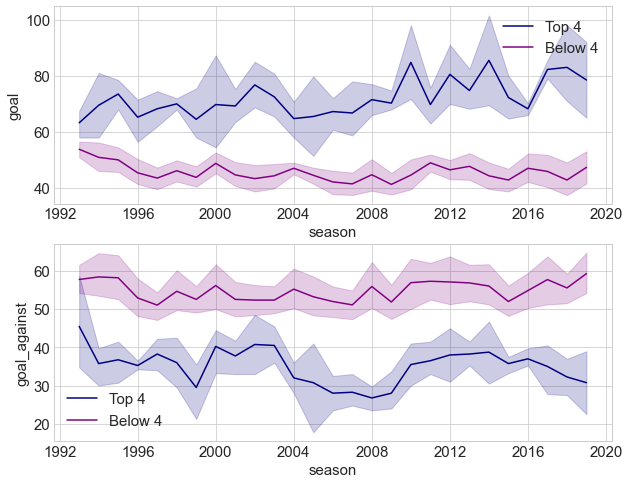

In [20]:
f, axes = plt.subplots(2, 1,figsize=(10, 8))

for i in range(len(goals)):
    sns.lineplot(top4['season'], top4[goals[i]], label=('Top 4'), color='navy',ax=axes[i])
    sns.lineplot(below4['season'], below4[goals[i]], label=('Below 4'), color='purple', ax=axes[i])
    axes[i].tick_params(labelsize=15)
    axes[i].set_ylabel(goals[i], fontsize=15)
    axes[i].set_xlabel('season', fontsize=15)
    axes[i].legend(fontsize=15) 

plt.savefig('goal_timeline.jpg')

**It looks like there is no difference between past and current in term of how many win, lost, draw games are needed to be in the top 4.**

In [21]:
features = ['aerial_battles', 'big_chance_created', 'clearance', 'cross', 'cross_accuracy', 'goal_conceded_per_match', 
            'goal_per_match', 'interceptions', 'pass_accuracy', 'pass_per_game', 'shooting_accuracy', 'shot_on_target', 'tackle_success']

**The data before season 2006 have many features that are zero due to the reason as follows:**  
"When the Premier League began in 1992/93, only a basic level of match data was gathered. Over time this has increased and since 2006/07 a wide range of statistics are now provided. The information below shows a breakdown of the statistics on the Premier League website and the season this data originated." **from EPL offical website, https://www.premierleague.com/stats/clarification**

In [107]:
top4_feat = top4[top4['season'] > datetime.date(2006,1,1)]
below4_feat = below4[below4['season'] > datetime.date(2006,1,1)]

In [ ]:
e_barplot(below4_feat, top4_feat, features, w=10, h=20,
         t_fsize=20, label_size=20, n_labels= ['Below4', 'Top 4'],
         func='average', vis_col=2, vis_row=7)

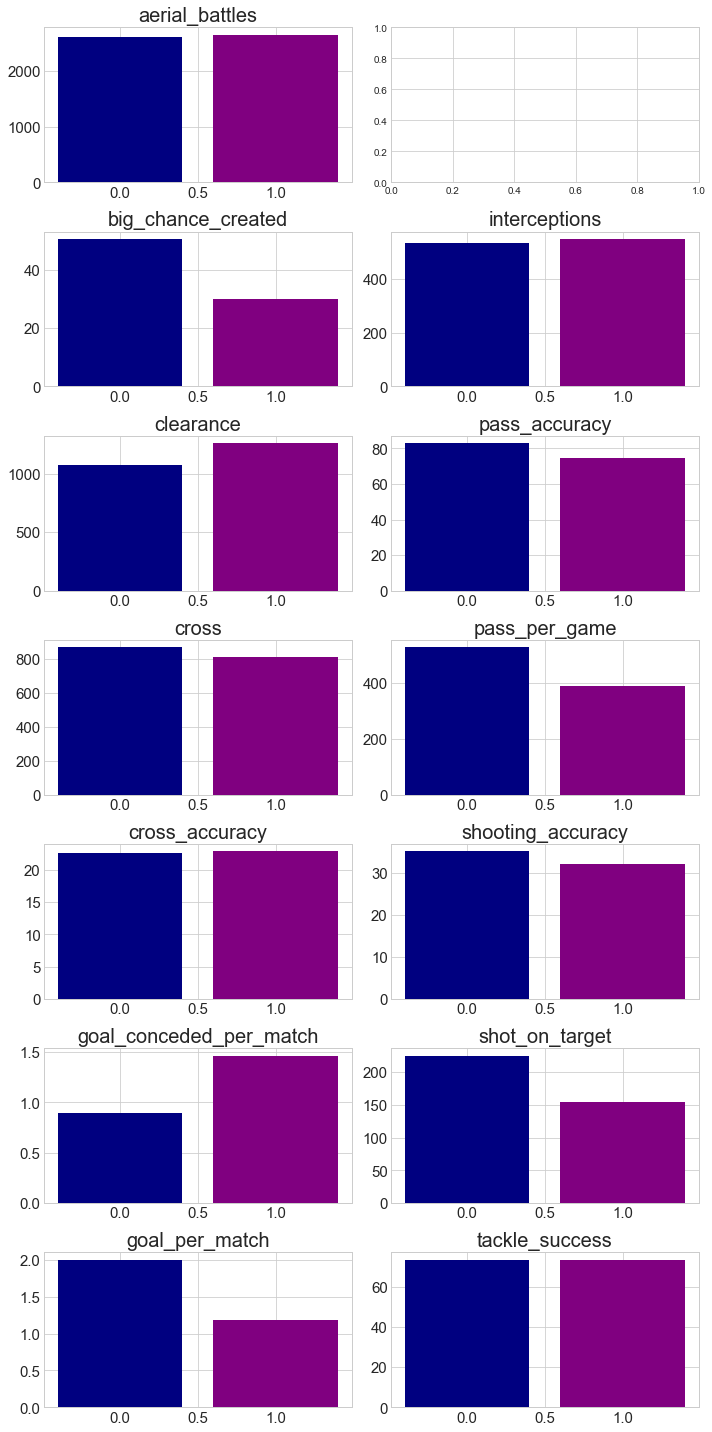

In [95]:
f, axs = plt.subplots(7, 2, figsize=(10,20))

for i in range(len(features)):
    if i <= 6:
        axs[i, 0].bar(0, np.average(top4[top4['season'] > datetime.date(2006,1,1)][features[i]]), 
                      color='navy',label='Top 4')
        axs[i, 0].bar(1, np.average(below4[below4['season'] > datetime.date(2006,1,1)][features[i]]), 
                      color='purple',label='Below 4')
        axs[i, 0].set_title(features[i], fontsize=20)
        axs[i, 0].tick_params(labelsize=15)
        plt.tight_layout()
    else:
        axs[i-6, 1].bar(0, np.average(top4[top4['season'] > datetime.date(2006,1,1)][features[i]]), 
                        color='navy', label='Top 4')
        axs[i-6, 1].bar(1, np.average(below4[below4['season'] > datetime.date(2006,1,1)][features[i]]), 
                        color='purple',label='Below 4')
        axs[i-6, 1].set_title(features[i], fontsize=20)
        axs[i-6, 1].tick_params(labelsize=15)
        plt.tight_layout()
plt.savefig('factors.jpg')

**The significant different features between Top 4 and Below 4 clubs are 'big_chance_created', 'goal_conceded_per_match', 'goal_per_match', 'pass_per_game', and 'shot_on_target'**  
**In this plots, an interesting part is features that are significant different are kind of obvious features that related to win a match, but there are several features that**

In [23]:
top_corr = top4.corr()
below_corr = below4.corr()

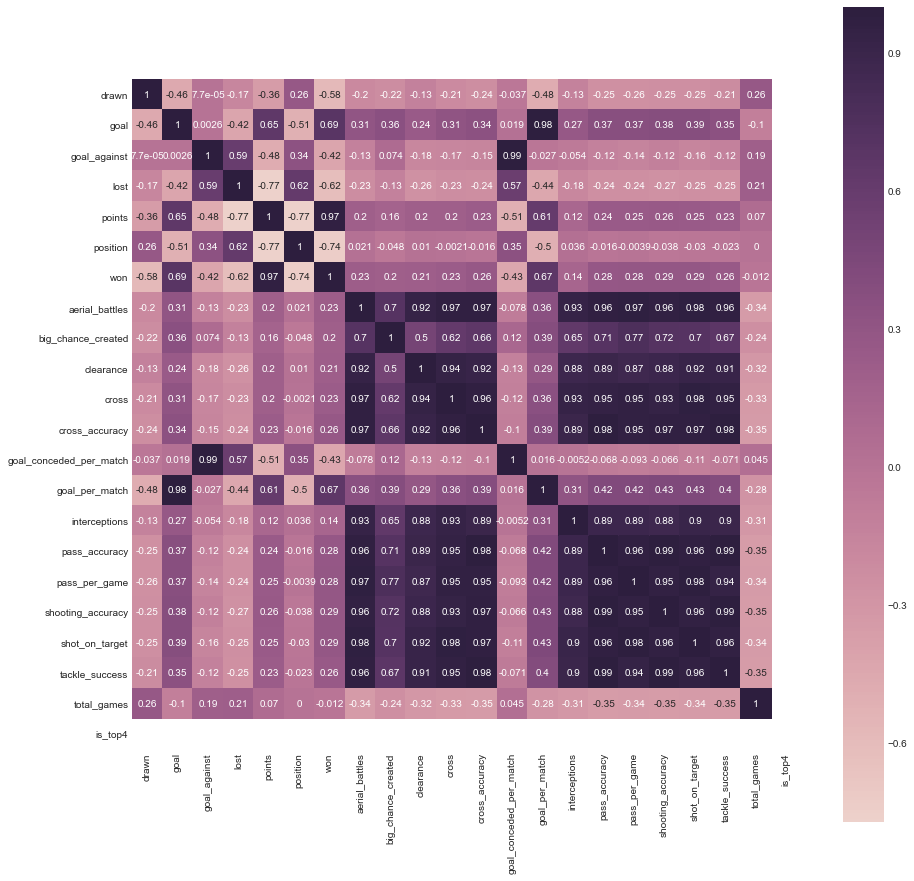

In [24]:
plt.figure(figsize=(15,15))
sns.heatmap(top_corr, mask=np.zeros_like(top_corr, dtype=np.bool), annot=True, 
            cmap=sns.cubehelix_palette(as_cmap=True), square=True)
plt.show()

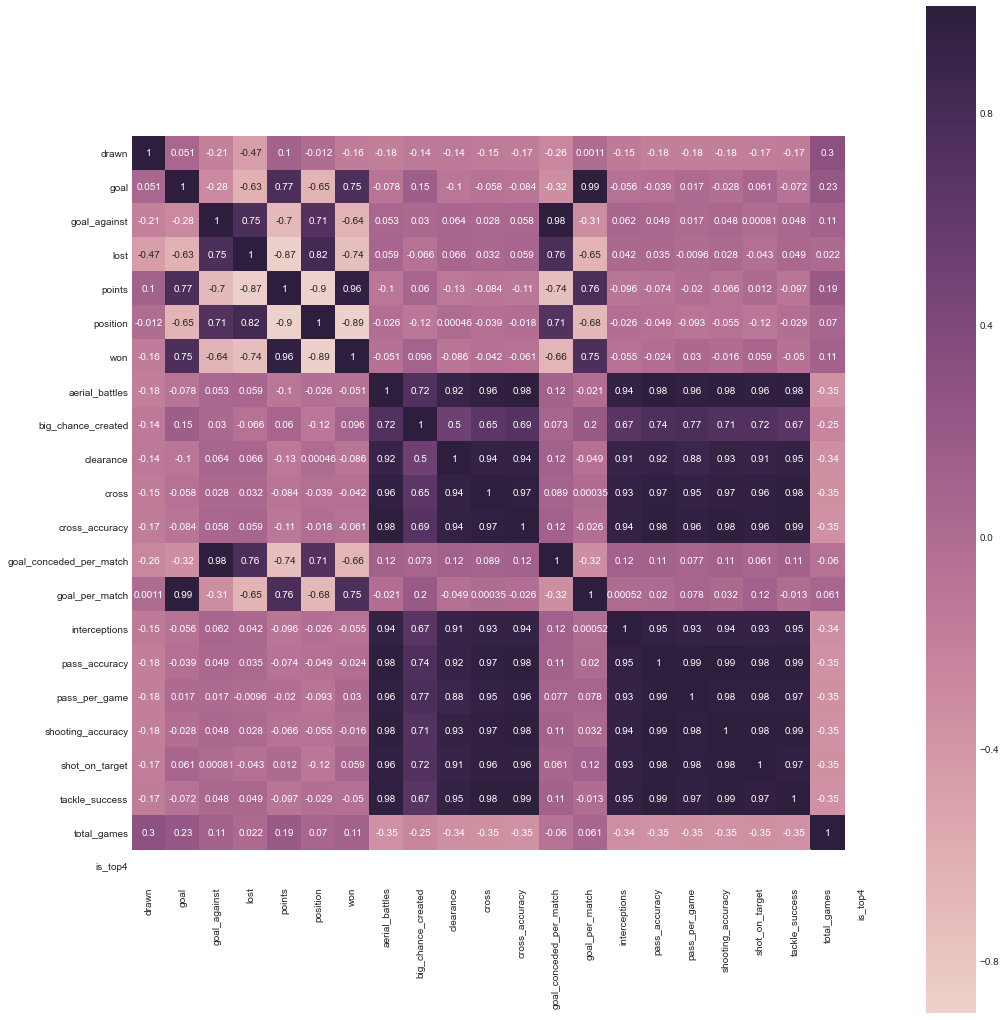

In [25]:
plt.figure(figsize=(15,15))
sns.heatmap(below_corr, mask=np.zeros_like(below_corr, dtype=np.bool), annot=True, 
            cmap=sns.cubehelix_palette(as_cmap=True), square=True)
plt.tight_layout()
plt.show()